## Bibliotecas

In [1]:
import random
import math
import time

import pandas as pd
import matplotlib.pyplot as plt

from functools import partial
from scipy.stats import t, chi2

## Variáveis globais

In [2]:
# N_RODADAS = 3200
N_RODADAS = 20

# N_AMOSTRAS = 10000
N_AMOSTRAS = 100_000

RHOS = [0.2, 0.4, 0.6, 0.8, 0.9]

CHEGADA = 0
FIM_DO_SERVICO_1 = 1
FIM_DO_SERVICO_2 = 2

MU = 1.0

LIVRE = 0
OCUPADO = 1

FCFS = 1
LCFS = 0

## Funcionamento geral

### Gerando VAs exponenciais
Resultado mostrado na aula 5, slide 5.

In [3]:
def gera_exponencial(rho):

    # Gera VA uniforme no intervalo [0.0, 1.0)
    u0 = random.random()

    # Pega amostra da exponencial
    x0 = -math.log(u0)/ rho

    return x0

### Gerando números aleatórios
Os seeds em Python são definidos por meio da função random.seed(int) e fixamos um seed antes cada simulação para garantir a reprodutibilidade dos resultados. Para garantir a independência dos seeds, rodamos o algoritmo com alguns seeds diferentes ao longo do trabalho.

Além disso também fizemos alguns testes para mostrar que não há sobreposição entre os intervalos gerados pelos seeds.

Mesmo usando seeds próximas (0 e 1, por exemplo) não encontramos sobreposição das sequências de valores nem uma correlação significativa. Acreditamos que isso se deve ao fato de o Python utilizar o algoritmo do Mersenne Twister para gerar números pseudoaleatórios (https://en.wikipedia.org/wiki/Mersenne_Twister).

In [4]:
def gera_amostras(rho, seed):

    rodadas = []

    random.seed(seed)
    
    for _ in range(N_RODADAS):
        amostras = []

        for _ in range(N_AMOSTRAS):
            amostras.append(gera_exponencial(rho))
        
        rodadas.append(amostras)
    
    # Lista de rodadas com números aleatórios gerados pela amostra exponencial
    return rodadas

#### Teste 1

Primeiro geramos 2 vetores com váriaveis exponenciais com mesma taxa, cada um a partir de uma seed diferente. E depois verificamos se existem valores em comuns nesses vetores.

In [5]:
def teste_gera_amostras(rodadas_A, rodadas_B):

    tamanho_lista_rodadas = len(rodadas_A)

    for rodada_A in range(tamanho_lista_rodadas - 1):
        lista_rodada = rodadas_A[rodada_A]

        for rodada_B in range(tamanho_lista_rodadas):
            verifica_lista = rodadas_B[rodada_B]

            verificacao = list(set(lista_rodada).intersection(verifica_lista))
            if(len(verificacao) > 0):
                return "Foram encontrados valores iguais"
            
    return "Não há valores iguais entre as duas rodadas"       

Exemplo:

In [6]:
rodadas_A = gera_amostras(0.3, 0)
rodadas_B = gera_amostras(0.3, 1)

teste_gera_amostras(rodadas_A, rodadas_B)

'Não há valores iguais entre as duas rodadas'

#### Teste 2

No outro teste geramos 2 vetores também e verificamos o indíce de correlação (Pearson) entre eles.

- +1: correlação positiva completa
- +0.8: correlação positiva forte
- +0.6: correlação positiva moderada
- 0: nenhuma correlação
- -0.6: correlação negativa moderada
- -0.8: correlação negativa forte
- -1: correlação negativa completa

Referência: https://stackabuse.com/calculating-pearson-correlation-coefficient-in-python-with-numpy/


In [7]:
def teste_pearson_gera_amostras(seed_1, seed_2):

    rodadas = []
    amostras_1 = []
    amostras_2 = []

    random.seed(seed_1)
    for _ in range(N_AMOSTRAS):
        amostras_1.append(random.random())
    rodadas.append(amostras_1)

    random.seed(seed_2)
    for _ in range(N_AMOSTRAS):
        amostras_2.append(random.random())
    rodadas.append(amostras_2)

    x_pearson = pd.Series(rodadas[0])
    y_pearson = pd.Series(rodadas[1])

    resultado = x_pearson.corr(y_pearson)

    return resultado

Exemplo:

In [8]:
teste_pearson_gera_amostras(0, 1)

0.0021411007061130304

### Eventos

In [9]:
class Evento:

    def __init__(self, tipo_evento, instante_t, tempo_execucao, id_cliente):
        self.tipo_evento = tipo_evento
        self.instante_t = instante_t #tempo em que o evento foi criado + tempo até ser executado
        self.tempo_execucao = tempo_execucao #tempo até ser executado
        self.id_cliente = id_cliente

    # Define como a classe é impressa
    def __repr__(self):
        if(self.tipo_evento == CHEGADA):
            escreve_string = "CHEGADA"
        elif self.tipo_evento == FIM_DO_SERVICO_1:
            escreve_string = "FIM DO SERVIÇO 1"
        else:
            escreve_string = "FIM DO SERVIÇO 2"

        return f"Tipo de evento: {escreve_string}\n Instante: {self.instante_t}\n ID Cliente: {self.id_cliente}"

Exemplo:

In [10]:
evento = Evento(CHEGADA, 0.1, 0, 0)
evento

Tipo de evento: CHEGADA
 Instante: 0.1
 ID Cliente: 0

### Clientes

In [11]:
class Cliente:

    def __init__(self, chegada_evento, cor):
        self.id = chegada_evento.id_cliente
        self.tempo_chegada = chegada_evento.instante_t
        self.tempo_execucao_1 = 0.0
        self.tempo_execucao_2 = 0.0
        self.tempo_espera_1 = 0.0
        self.tempo_espera_2 = 0.0
        self.cor = cor

    # Define como a classe é impressa
    def __repr__(self):
        return f"""ID: {self.id}
        Tempo de chegada: {self.tempo_chegada}
        Tempo de espera na fila 1: {self.tempo_espera_1}
        Tempo de execucao no servico 1: {self.tempo_execucao_1}
        Tempo de espera na fila 2: {self.tempo_espera_2}
        Tempo de execucao no servico 2: {self.tempo_execucao_2}"""

In [12]:
def cria_cliente(evento, cor):
    novo_cliente = Cliente(evento, cor)
    return novo_cliente

Exemplo:

In [13]:
cor = "%06x" % random.randint(0, 0xFFFFFF)
cliente = cria_cliente(evento, cor)
cliente

ID: 0
        Tempo de chegada: 0.1
        Tempo de espera na fila 1: 0.0
        Tempo de execucao no servico 1: 0.0
        Tempo de espera na fila 2: 0.0
        Tempo de execucao no servico 2: 0.0

### Gerando chegadas

In [14]:
def gera_chegadas(instante_t, distribuicao_chegada, id_cliente):
    chegada = distribuicao_chegada()
    chegada = Evento(CHEGADA, instante_t + chegada, chegada, id_cliente)
    return chegada

Exemplo:

In [15]:
chegada = gera_chegadas(1, partial(gera_exponencial, 0.3), 0)
chegada

Tipo de evento: CHEGADA
 Instante: 2.886248837747606
 ID Cliente: 0

### Gerando fins de serviço

In [16]:
def gera_fim_servico(instante_t, distribuicao_servico, id_cliente, tipo):
    servico = distribuicao_servico()
    fim_servico = Evento(tipo, instante_t + servico, servico, id_cliente)
    return fim_servico

Exemplo:

In [17]:
fim_servico = gera_fim_servico(10, partial(gera_exponencial, 0.3), 1, FIM_DO_SERVICO_1)
fim_servico

Tipo de evento: FIM DO SERVIÇO 1
 Instante: 12.428633374477153
 ID Cliente: 1

### Intervalos de confiança

#### T-Student
Resultado apresentado na aula 7, slides 4 e 6.

In [18]:
def t_student(media, variancia, amostras):
    t_student_percentil = t(df = amostras - 1).ppf((0.025, 0.975))[1]

    # Verifica se a média e variância têm valores nulos (ou próximos disso)
    if(math.isclose(media, 0, abs_tol = 1e-9)):
        media = 0

    if(math.isclose(variancia, 0, abs_tol = 1e-9)):
        variancia = 0

    # Se a média e variância forem nulas
    if(not(media or variancia)):
        return 0.0, 0.0, 0.0

    desvio_padrao = math.sqrt(variancia)

    # Metade do intervalo
    metade = t_student_percentil * (desvio_padrao/ math.sqrt(amostras))

    # Limite superior do intervalo
    limite_superior = media + metade

    # Limite inferior do intervalo
    limite_inferior = media - metade

    # Precisão do intervalo
    precisao = metade/ media

    return media, limite_superior, limite_inferior, precisao

#### Chi-Quadrado
Resultado apresentado na aula 7, slides 12 ao 14.

In [19]:
def chi_quadrado(variancia, amostras):
    chi2_0025_percentil, chi2_0975_percentil = chi2(df = amostras - 1).ppf((0.025, 0.975))

    if(variancia == 0.0):
        return 0.0, 0.0, 0.0

    else:
        limite_inferior = (amostras) * variancia/ chi2_0975_percentil
        limite_superior = (amostras) * variancia/ chi2_0025_percentil

        # Enunciado pede que seja aproximadamente 0.05
        precisao = (chi2_0975_percentil - chi2_0025_percentil)/ (chi2_0975_percentil + chi2_0025_percentil)

        return limite_superior, limite_inferior, precisao

In [56]:
chi_quadrado(10, 3071)

(10.523163878420796, 9.521109001719836, 0.049992079168597374)

### Estimadores

Essa classe permitey o cálculo iterativo da média e da variãncia de uma variável, recebendo uma amostra de cada vez.
Esse resultado foi apresentado na aula 7, slide 19.

In [21]:
class Estimador:

    def __init__(self, debug=False):
        self.soma_amostras = 0.0
        self.quadrado_soma_amostras = 0.0
        self.numero_amostras = 0
        self.debug = debug
        
        self.medias = []
        self.variancias = []
        self.pesos = []

    def adiciona_amostra(self, amostra, peso=1):
        #peso = 1
        self.soma_amostras += amostra*peso
        self.quadrado_soma_amostras += ((amostra) ** 2)
        self.numero_amostras += peso
        
        #salvar resultados intermediários para plots futuros
        if self.debug and self.numero_amostras > 2:
            self.pesos.append(self.numero_amostras)
            self.medias.append(self.media())
            self.variancias.append(self.variancia())

    def media(self):
        return self.soma_amostras/ self.numero_amostras

    def variancia(self):
        termo_auxiliar_1 = self.quadrado_soma_amostras/ (self.numero_amostras - 1)
        termo_auxiliar_2 = (self.soma_amostras ** 2)/ (self.numero_amostras * (self.numero_amostras - 1))
        return termo_auxiliar_1 - termo_auxiliar_2

    def t_student(self):
        return t_student(self.media(), self.variancia(), self.numero_amostras)

    def variancia_chi_quadrado(self):
        return chi_quadrado(self.variancia(), self.numero_amostras)

    def chi_quadrado(self):
        return chi_quadrado(self.media(), self.numero_amostras)

In [22]:
estimador = Estimador(debug=True)
estimador.adiciona_amostra(10)
estimador.adiciona_amostra(11)
estimador.adiciona_amostra(10)
estimador.adiciona_amostra(10)
estimador.adiciona_amostra(10)
estimador.adiciona_amostra(10)
estimador.t_student()[2]

9.738236360564203

## Simulador

### Base

Código base para simular o sistema com prints depurativos para acompanhar chegadas

In [23]:
random.seed(13) #setando uma seed pra manter os testes iguais

mu = MU
lamb = RHOS[2]/2

fila1 = []
fila2 = []
tempo = 0
eventos = [ gera_chegadas(0, partial(gera_exponencial, lamb), 0) ] # começa populando com uma chegada

i = 1
while i < 10: #loop de eventos, chegada de 10 clientes
    atual = eventos.pop(0)
    tempo = atual.instante_t
    print("Tempo", tempo)
    
    if atual.tipo_evento == CHEGADA: #evento de chegada
        fila1.append( cria_cliente(atual, cor) ) #adiciona o cliente chegado na fila
        eventos.append(gera_chegadas(tempo, partial(gera_exponencial, lamb), i) ) #cria o próximo evento de chegada
        print("Chegada", fila1[-1])
        
        checa_termino = any([e.tipo_evento == FIM_DO_SERVICO_1 for e in eventos])
        if not checa_termino: #essa foi a primeira chegada (não tem pessoas na fila 1)
            prox_fim_1 = gera_fim_servico(tempo, partial(gera_exponencial, mu), atual.id_cliente, FIM_DO_SERVICO_1) 
            eventos.append( prox_fim_1 ) #adiciona o próximo evento de término 1
            
            if len(fila2) != 0: # fila 2 tem alguém sendo executado
                prox_fim_2 = [e for e in eventos if e.tipo_evento == FIM_DO_SERVICO_2][0] #próximo término da fila 2
                prox_fim_2.instante_t += prox_fim_1.tempo_execucao #adia o fim do próximo da fila 2 para após o fim do atual da fila 1
        i+= 1
    
    elif atual.tipo_evento == FIM_DO_SERVICO_1:
        cliente = fila1.pop(0) #remove o primeiro da fila 1
        fila2.append( cliente ) #coloca cliente na fila 2
        
        #atualiza tempos do cliente
        cliente.tempo_execucao_1= atual.tempo_execucao
        cliente.tempo_espera_1 = tempo - cliente.tempo_chegada - atual.tempo_execucao
        
        checa_termino = any([e.tipo_evento == FIM_DO_SERVICO_2 for e in eventos])
        if not checa_termino: #essa foi o primeiro termino (não tem pessoas na fila 2)
            eventos.append( gera_fim_servico(tempo, partial(gera_exponencial, mu), cliente.id, FIM_DO_SERVICO_2) ) #adiciona o próximo evento de término 1
        
        if len(fila1) == 0: #se a fila 1 estiver vazia
            pass
        else: #se a fila 1 não estiver vazia
            prox_fim_1 = gera_fim_servico(tempo, partial(gera_exponencial, mu), fila1[0].id, FIM_DO_SERVICO_1)  #cria evento de término para o próximo da fila 1
            eventos.append( prox_fim_1 ) 
            
            prox_fim_2 = [e for e in eventos if e.tipo_evento == FIM_DO_SERVICO_2][0] #próximo término da fila 2
            prox_fim_2.instante_t += prox_fim_1.tempo_execucao #adia o fim do próximo da fila 2 para após o fim do atual da fila 1
        
        print("Saída 1", cliente)
        
    elif atual.tipo_evento == FIM_DO_SERVICO_2:
        cliente = fila2.pop(0)
        
        #atualiza tempos do cliente
        cliente.tempo_execucao_2= atual.tempo_execucao
        cliente.tempo_espera_2 = tempo - cliente.tempo_chegada - cliente.tempo_execucao_1 - cliente.tempo_espera_1 - atual.tempo_execucao
        
        if len(fila2) != 0:
            prox_fim_2 = gera_fim_servico(tempo, partial(gera_exponencial, mu), fila2[0].id, FIM_DO_SERVICO_2)
            eventos.append( prox_fim_2 )
            
        print("Saída 2", cliente)

    eventos.sort(key = lambda e: e.instante_t)
    print(eventos)
    print()
#eventos

Tempo 4.502981437579455
Chegada ID: 0
        Tempo de chegada: 4.502981437579455
        Tempo de espera na fila 1: 0.0
        Tempo de execucao no servico 1: 0.0
        Tempo de espera na fila 2: 0.0
        Tempo de execucao no servico 2: 0.0
[Tipo de evento: FIM DO SERVIÇO 1
 Instante: 4.88265904292863
 ID Cliente: 0, Tipo de evento: CHEGADA
 Instante: 5.762847702789278
 ID Cliente: 1]

Tempo 4.88265904292863
Saída 1 ID: 0
        Tempo de chegada: 4.502981437579455
        Tempo de espera na fila 1: -1.6653345369377348e-16
        Tempo de execucao no servico 1: 0.37967760534917544
        Tempo de espera na fila 2: 0.0
        Tempo de execucao no servico 2: 0.0
[Tipo de evento: FIM DO SERVIÇO 2
 Instante: 5.0459592641554
 ID Cliente: 0, Tipo de evento: CHEGADA
 Instante: 5.762847702789278
 ID Cliente: 1]

Tempo 5.0459592641554
Saída 2 ID: 0
        Tempo de chegada: 4.502981437579455
        Tempo de espera na fila 1: -1.6653345369377348e-16
        Tempo de execucao no servic

### Estimando a fase transiente

Para isso, colocamos a lógica do simulador em uma função e modificamos para salvar as métricas ao longo do tempo e fizemos alguns plots para visualizar onde elas se estabilizam.

In [24]:
def inicia_estimadores(debug = False):
    return {
        "W1": Estimador(debug = debug),
        "W2": Estimador(debug = debug),

        "T1": Estimador(debug = debug),
        "T2": Estimador(debug = debug),

        "N1": Estimador(debug = debug),
        "N2": Estimador(debug = debug),

        "Nq1": Estimador(debug = debug),
        "Nq2": Estimador(debug = debug)
    }

In [25]:
#lamb = lambda
#mu = mu
#n_transiente = tamanho da fase transiente
#n_eventos = número de eventos de saída da fila 2 em uma rodada
#n_rodadas = número de rodadas
def simulador_transiente(lamb, mu, n_transiente, n_eventos, n_rodadas, debug=False):
    fila1 = []
    fila2 = []

    tempo = 0
    tempo_anterior = 0

    eventos = [ gera_chegadas(0, partial(gera_exponencial, lamb), 0) ] # começa populando com uma chegada
    estimador_atual = inicia_estimadores(debug)
    estimadores_passados = []

    n_eventos_tratados = 0
    eventos_rodada = 0
    transiente = True
    rodada_atual = 0
    i=0
    
    while n_rodadas+1 > rodada_atual: #loop de eventos, tratar k clientes
        evento_atual = eventos.pop(0)
        if n_eventos_tratados == n_transiente:
            transiente = False
            eventos_rodada = 0
        
        tempo_anterior = tempo
        tempo = evento_atual.instante_t

        N1 = len(fila1)
        Nq1 = 0 if N1 == 0 else N1 - 1
        estimador_atual["N1"].adiciona_amostra(N1, peso=tempo-tempo_anterior)
        estimador_atual["Nq1"].adiciona_amostra(Nq1, peso=tempo-tempo_anterior)
        
        N2 = len(fila2)
        Nq2 = N2 if N1 > 0 or N2 == 0 else N2-1
        estimador_atual["N2"].adiciona_amostra(N2, peso=tempo-tempo_anterior)
        estimador_atual["Nq2"].adiciona_amostra(Nq2, peso=tempo-tempo_anterior)

        if evento_atual.tipo_evento == CHEGADA: #evento de chegada
            fila1.append( cria_cliente(evento_atual, rodada_atual) ) #adiciona o cliente chegado na fila
            eventos.append(gera_chegadas(tempo, partial(gera_exponencial, lamb), i) ) #cria o próximo evento de chegada

            checa_termino = any([e.tipo_evento == FIM_DO_SERVICO_1 for e in eventos])
            if not checa_termino: #essa foi a primeira chegada (não tem pessoas na fila 1)
                prox_fim_1 = gera_fim_servico(tempo, partial(gera_exponencial, mu), evento_atual.id_cliente, FIM_DO_SERVICO_1) 
                eventos.append( prox_fim_1 ) #adiciona o próximo evento de término 1

                if len(fila2) != 0: # fila 2 tem alguém sendo executado
                    prox_fim_2 = [e for e in eventos if e.tipo_evento == FIM_DO_SERVICO_2][0] #próximo término da fila 2
                    prox_fim_2.instante_t += prox_fim_1.tempo_execucao #adia o fim do próximo da fila 2 para após o fim do atual da fila 1
            i+= 1

        elif evento_atual.tipo_evento == FIM_DO_SERVICO_1:
            cliente = fila1.pop(0) #remove o primeiro da fila 1
            fila2.append( cliente ) #coloca cliente na fila 2

            #atualiza tempos do cliente
            cliente.tempo_execucao_1= evento_atual.tempo_execucao
            cliente.tempo_espera_1 = tempo - cliente.tempo_chegada - evento_atual.tempo_execucao

            checa_termino = any([e.tipo_evento == FIM_DO_SERVICO_2 for e in eventos])
            if not checa_termino: #essa foi o primeiro termino (não tem pessoas na fila 2)
                eventos.append( gera_fim_servico(tempo, partial(gera_exponencial, mu), cliente.id, FIM_DO_SERVICO_2) ) #adiciona o próximo evento de término 1

            if len(fila1) == 0: #se a fila 1 estiver vazia
                pass
            else: #se a fila 1 não estiver vazia
                prox_fim_1 = gera_fim_servico(tempo, partial(gera_exponencial, mu), fila1[0].id, FIM_DO_SERVICO_1)  #cria evento de término para o próximo da fila 1
                eventos.append( prox_fim_1 ) 

                prox_fim_2 = [e for e in eventos if e.tipo_evento == FIM_DO_SERVICO_2][0] #próximo término da fila 2
                prox_fim_2.instante_t += prox_fim_1.tempo_execucao #adia o fim do próximo da fila 2 para após o fim do atual da fila 1
            
            if not transiente and cliente.cor == rodada_atual:
                estimador_atual["W1"].adiciona_amostra(cliente.tempo_espera_1)
                estimador_atual["T1"].adiciona_amostra(cliente.tempo_espera_1+cliente.tempo_execucao_1)

        elif evento_atual.tipo_evento == FIM_DO_SERVICO_2:
            cliente = fila2.pop(0)

            #atualiza tempos do cliente
            cliente.tempo_execucao_2= evento_atual.tempo_execucao
            cliente.tempo_espera_2 = tempo - cliente.tempo_chegada - cliente.tempo_execucao_1 - cliente.tempo_espera_1 - evento_atual.tempo_execucao

            if len(fila2) != 0:
                prox_fim_2 = gera_fim_servico(tempo, partial(gera_exponencial, mu), fila2[0].id, FIM_DO_SERVICO_2)
                eventos.append( prox_fim_2 )
                
            if not transiente and cliente.cor == rodada_atual:
                estimador_atual["W2"].adiciona_amostra(cliente.tempo_espera_2)
                estimador_atual["T2"].adiciona_amostra(cliente.tempo_espera_2+cliente.tempo_execucao_2)
                eventos_rodada += 1
            n_eventos_tratados += 1 #aumenta contador de eventos de saída    
            
            if eventos_rodada ==n_eventos:
                eventos_rodada = 0
                rodada_atual += 1
                estimadores_passados.append(estimador_atual)
                estimador_atual = inicia_estimadores(debug)
            
        eventos.sort(key = lambda e: e.instante_t)
    return estimadores_passados
    #print(eventos)
    #print()
#estimadores["Nq2"].t_student()

In [27]:
# Função auxiliar para plotar os gráficos com diferentes seeds
def auxiliar_transiente(seed, n_saidas, n_testes):
    random.seed(seed) #setando uma seed pra manter os testes iguais
    dicionario = {r: [] for r in RHOS}
    
    for i in range(n_testes):
        for r in RHOS:
            mu = MU
            lamb = r/2
            start = time.time()
            estimadores = simulador_transiente(lamb, mu, 0, n_saidas, 1, debug=True)
            #print(f"Rho={r} demorou {time.time()-start:.2f} segundos")
            dicionario[r].append(estimadores[0])
        
    print(len(dicionario))
    #Plot dos resultados dos estimadores
    start = time.time()
    for i, cat in enumerate(["E[W1]", "V[W1]", "E[N1]", "E[Nq1]", "E[T1]", "E[W2]", "V[W2]", "E[N2]", "E[Nq2]", "E[T2]"]):
        fig, axs = plt.subplots(n_testes, figsize=(12, 24), sharex=True)
        m = cat[2:-1]
        
        for j in range(n_testes):
            for r, est in dicionario.items():
                valores = est[j][m].medias if cat[0] == "E" else est[j][m].variancias
                axs[j].plot(valores)
            axs[j].legend(RHOS)
        
        fig.subplots_adjust(hspace=0)
        axs[0].set_title(cat)
        plt.show()
    print(f"Plots demoraram {time.time()-start:.2f} segundos")

Usando seed 13

5


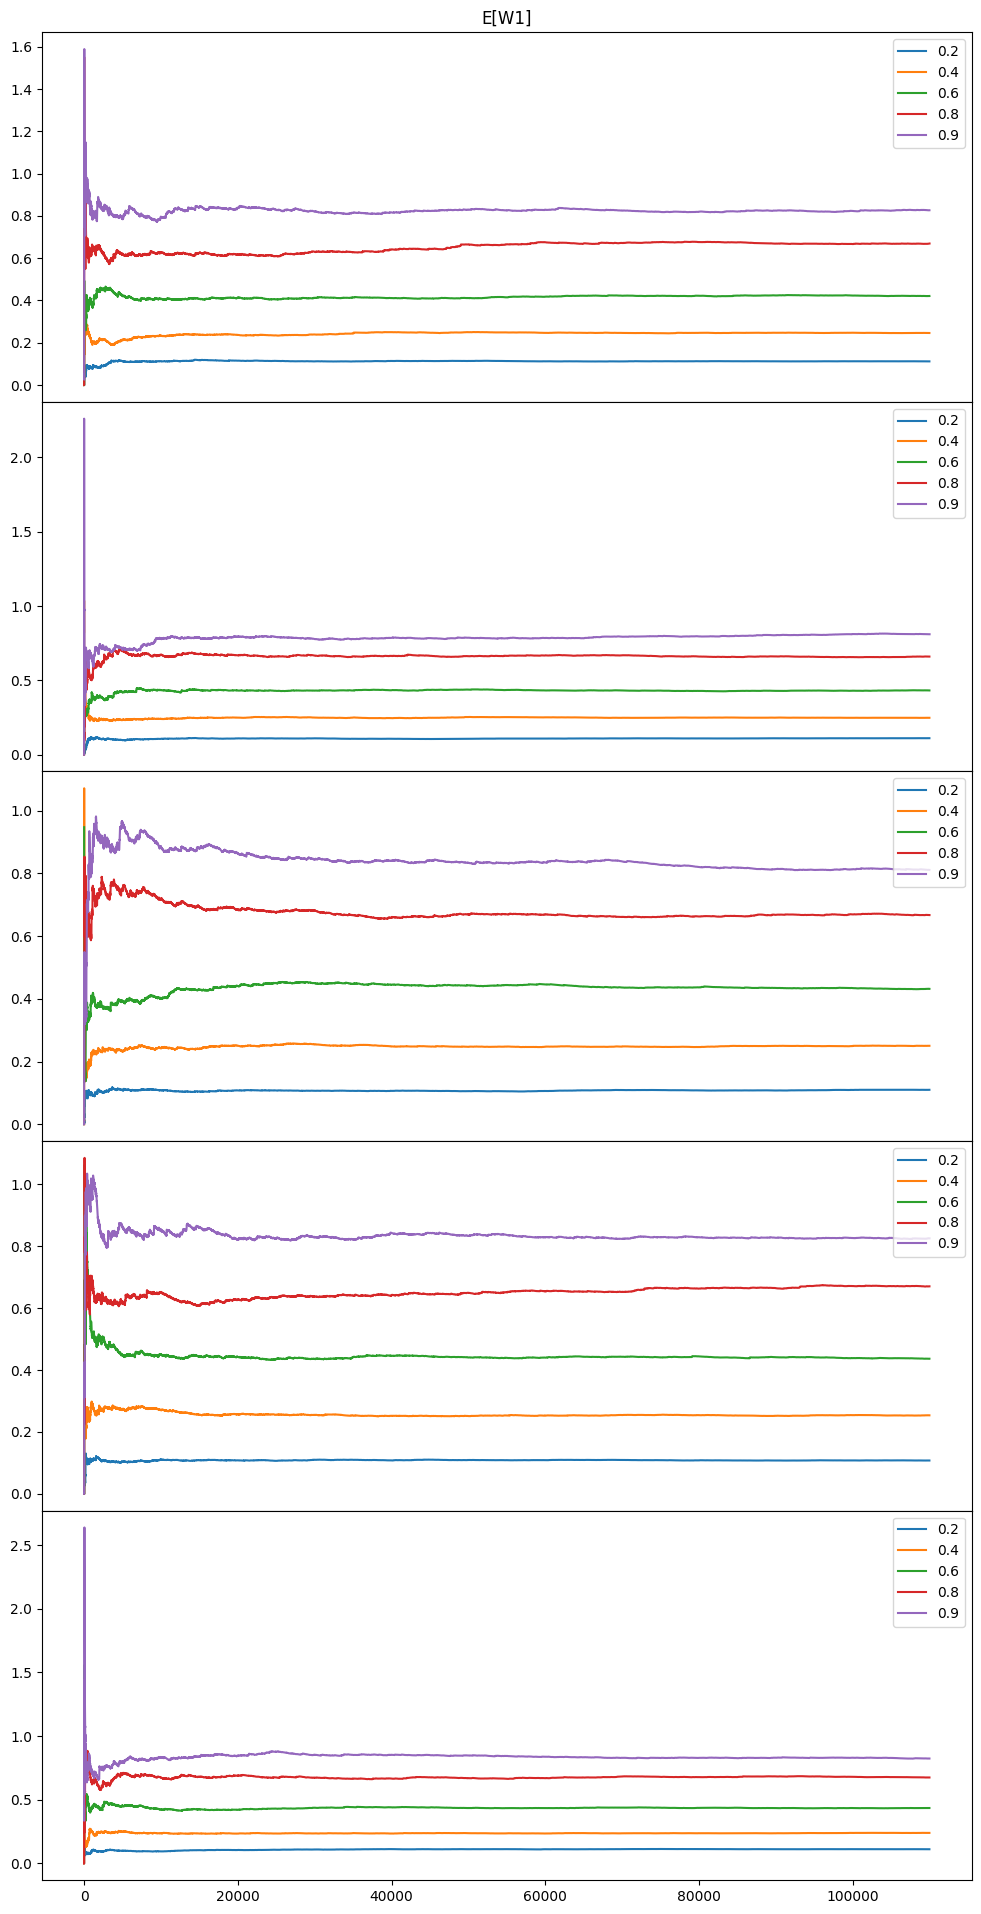

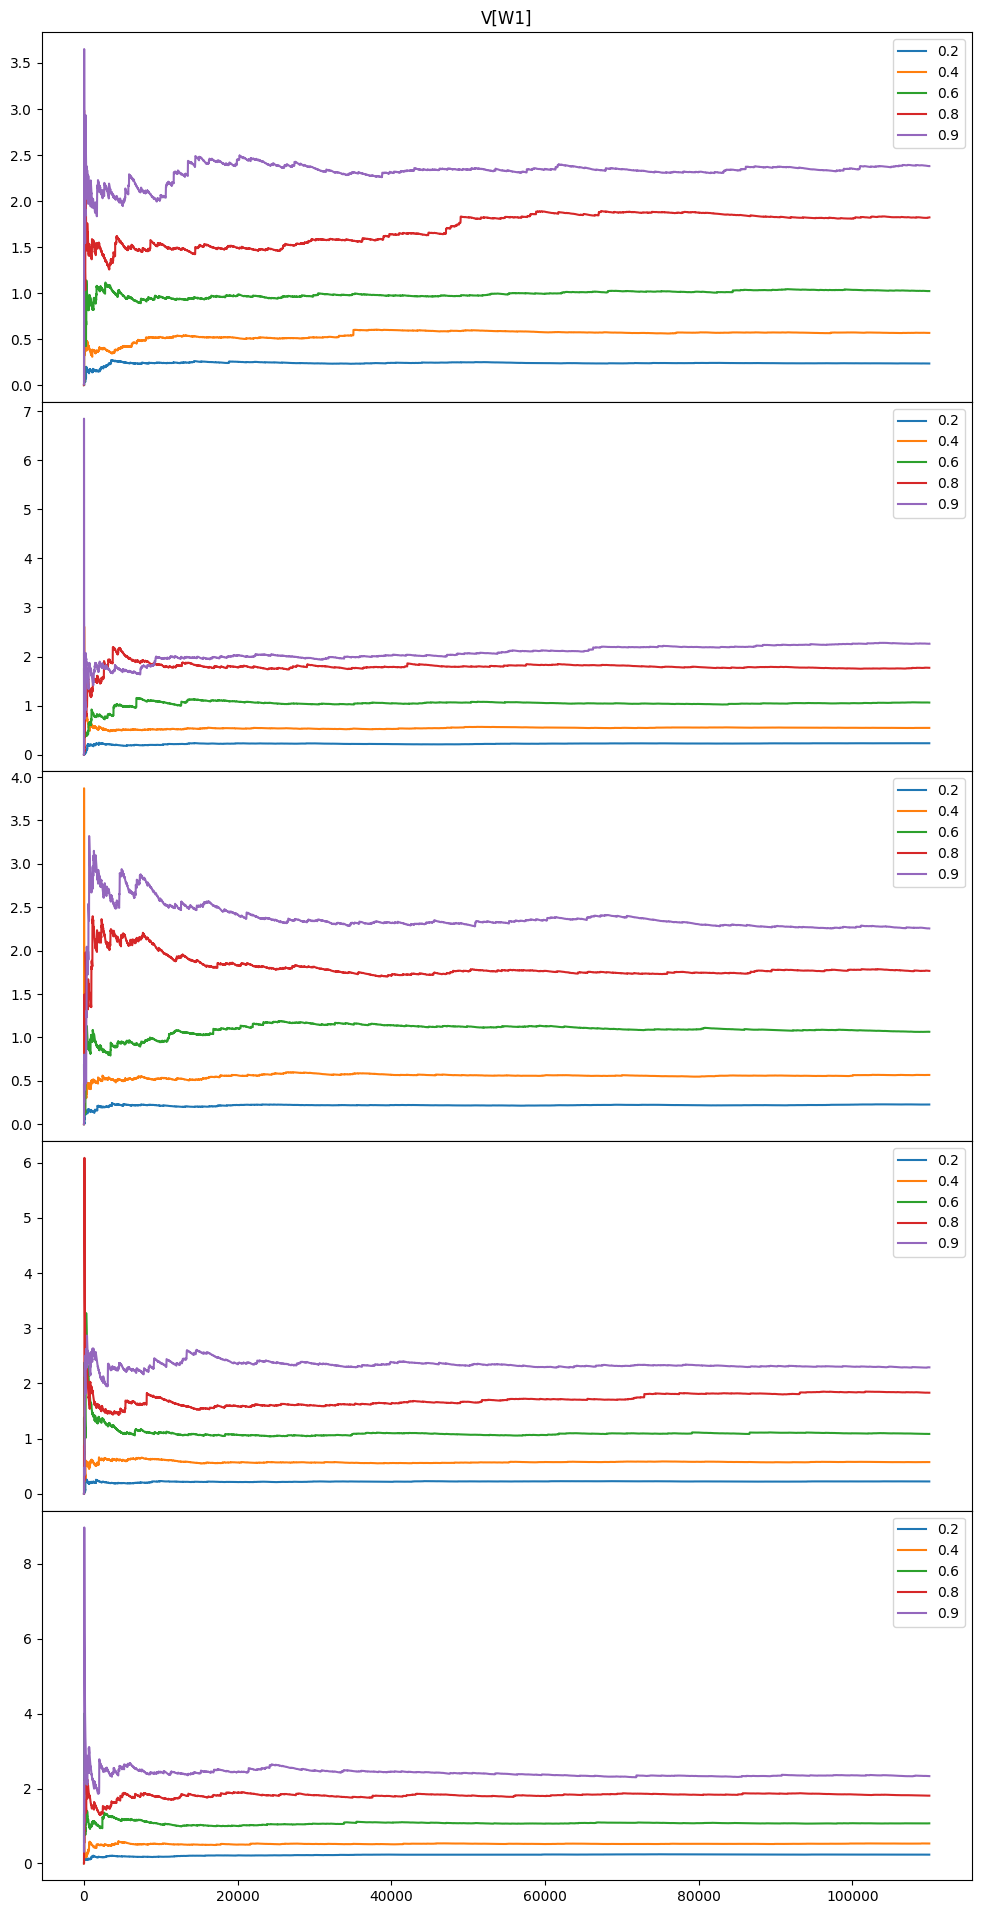

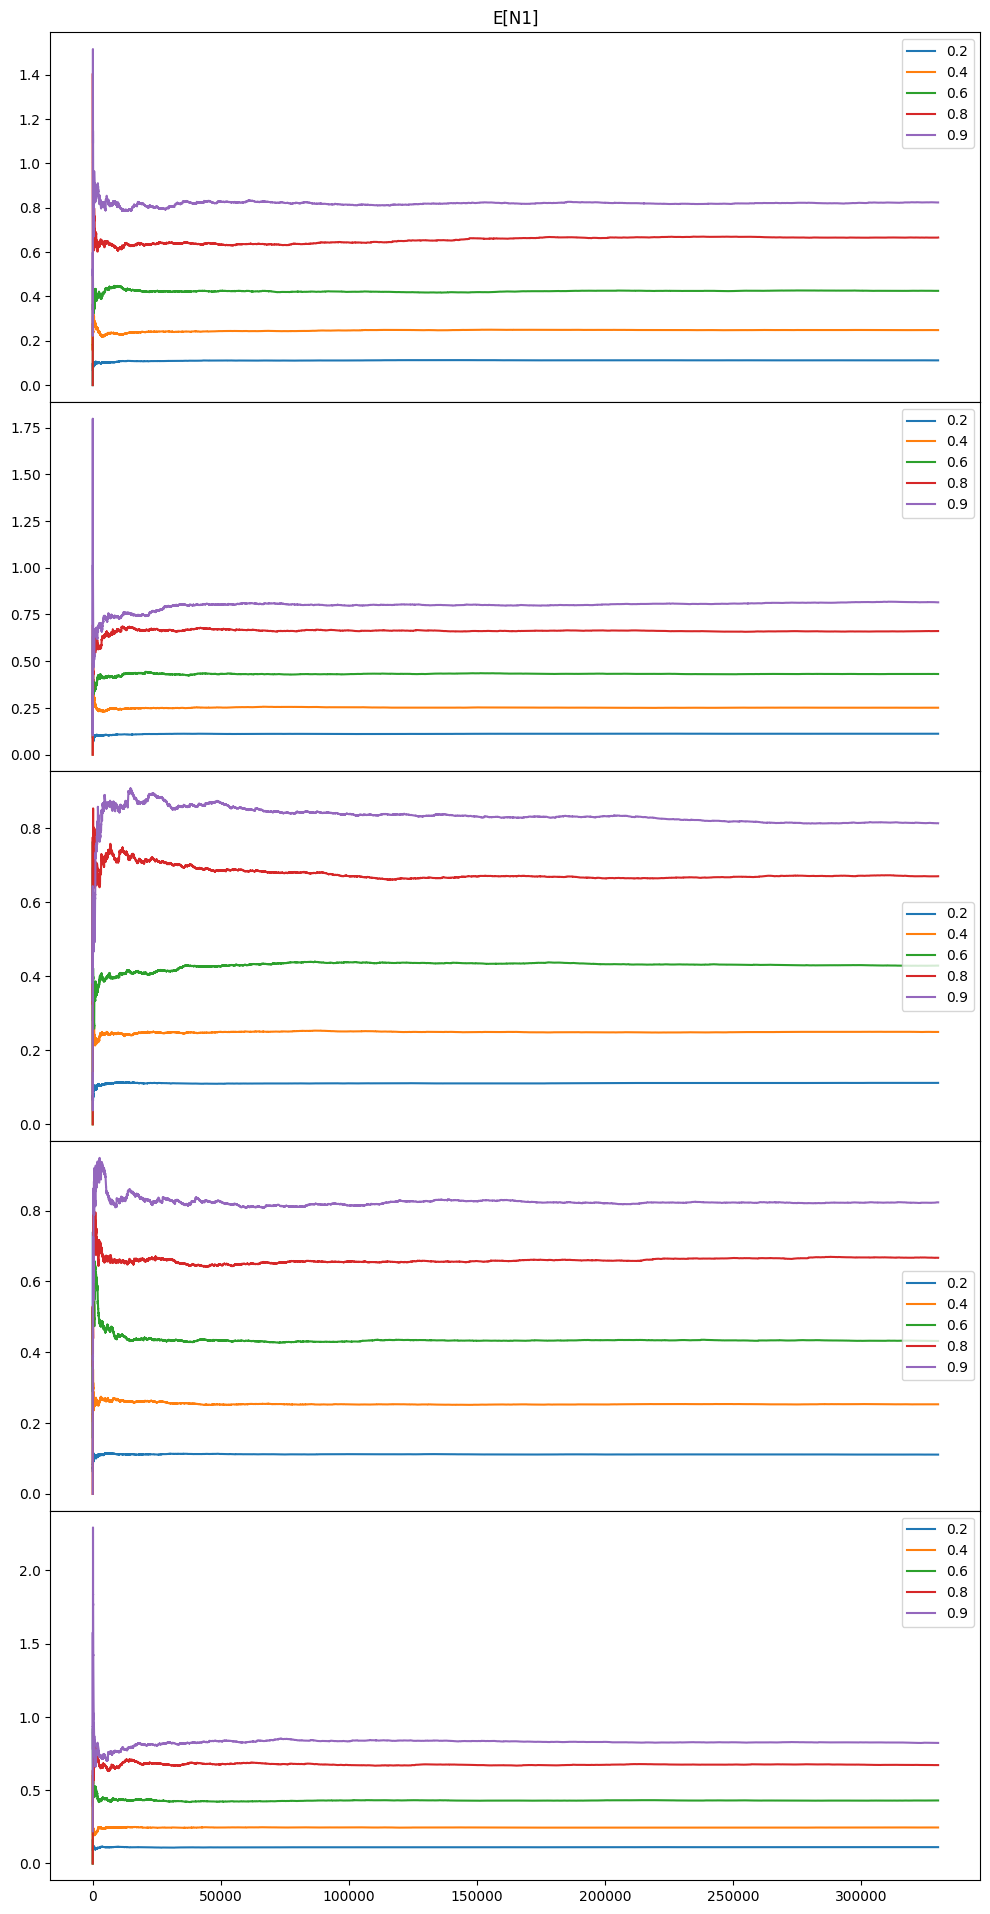

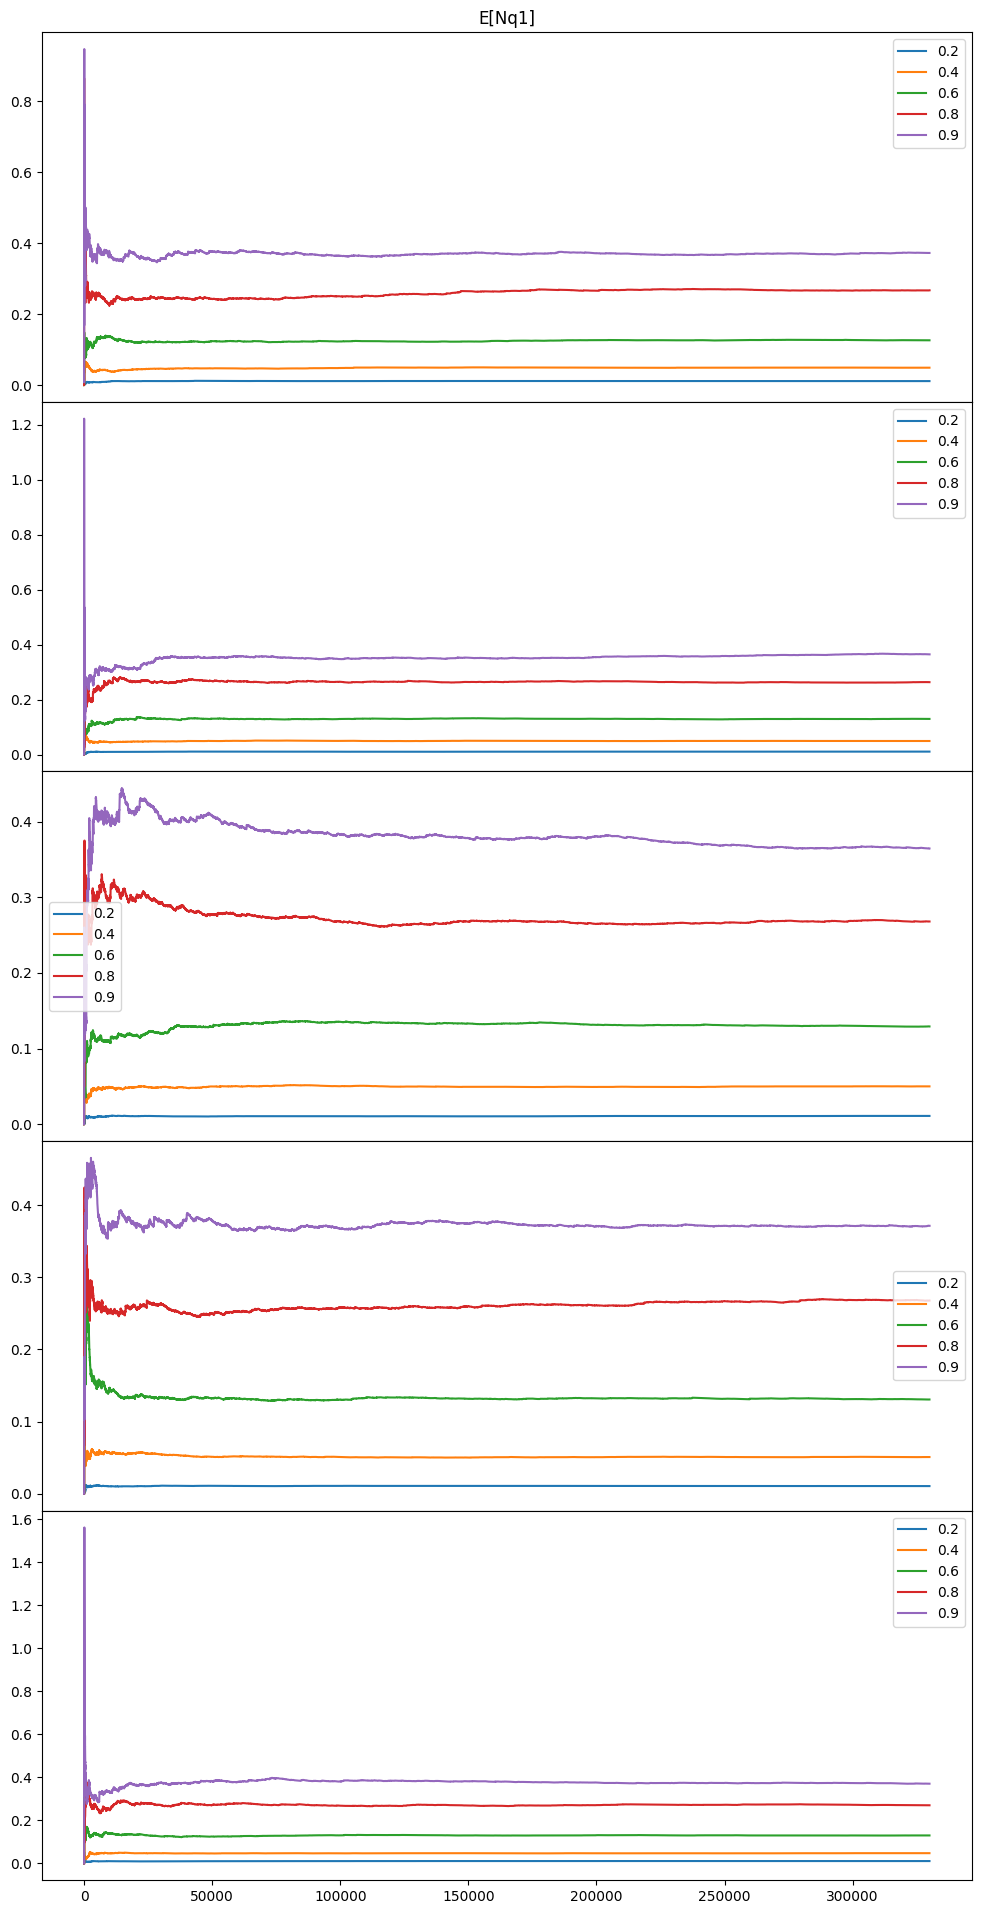

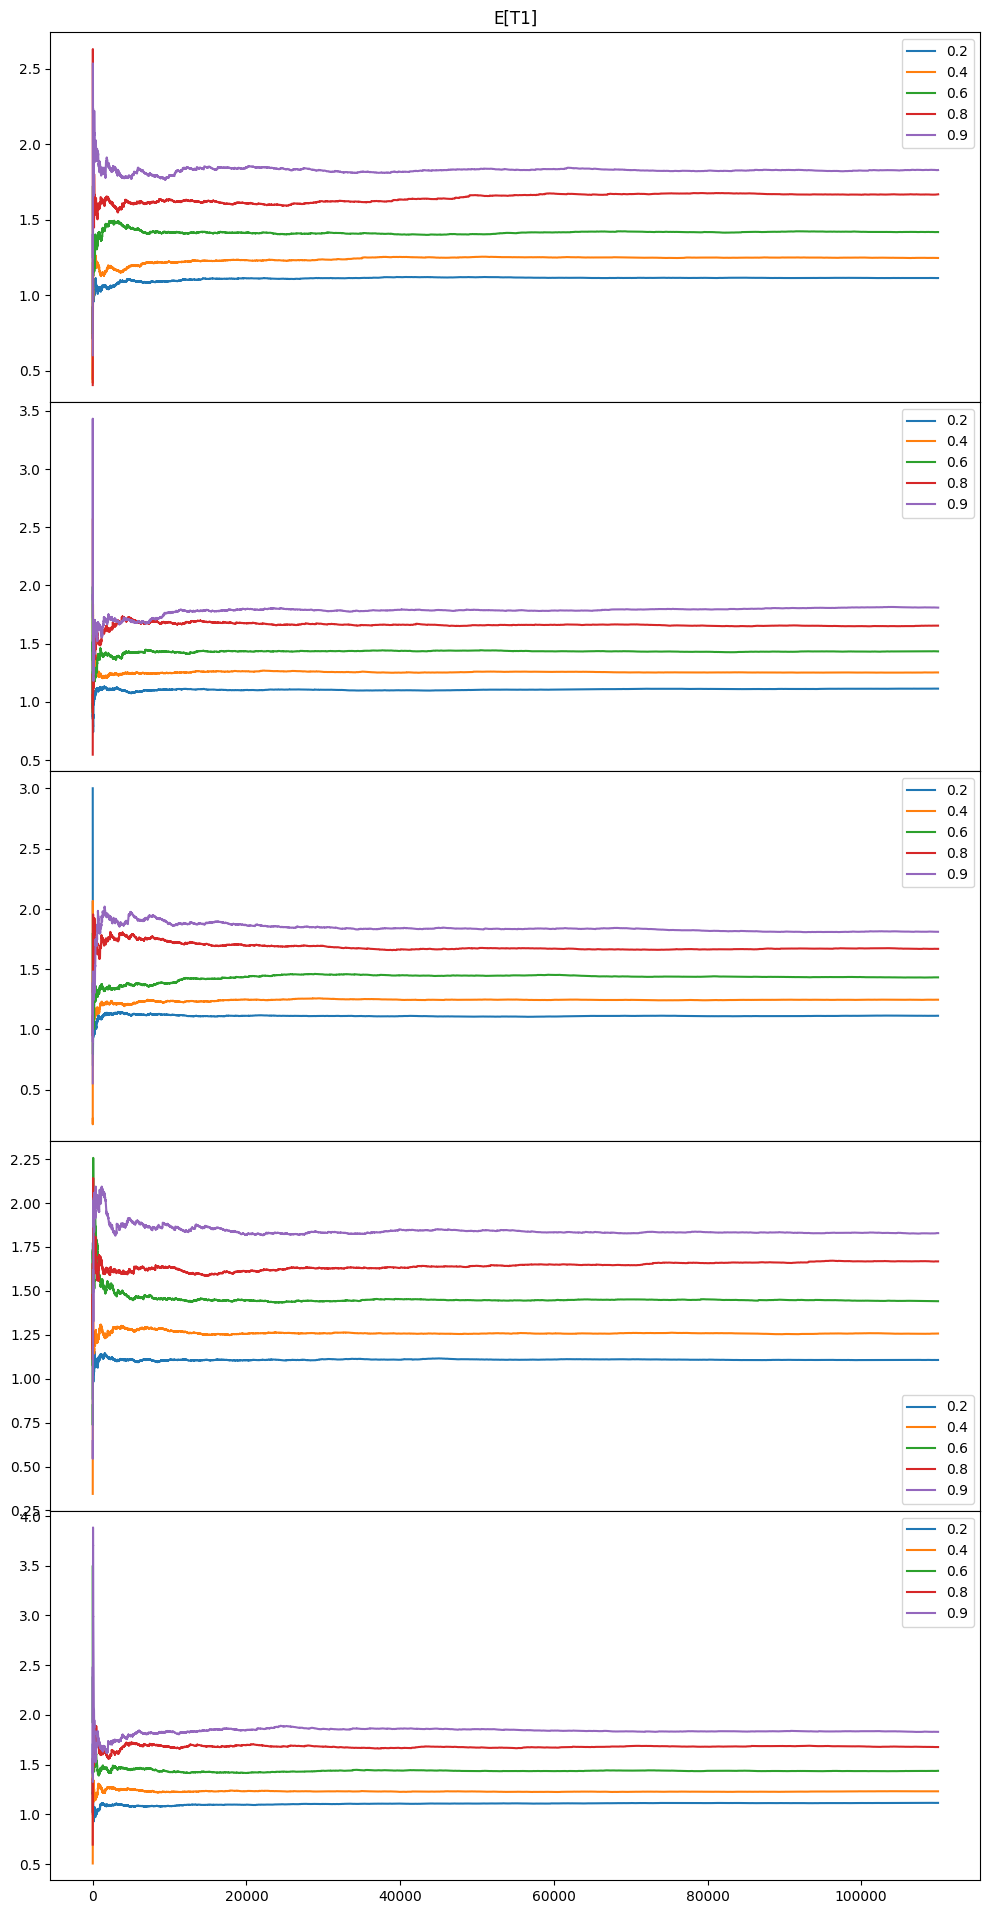

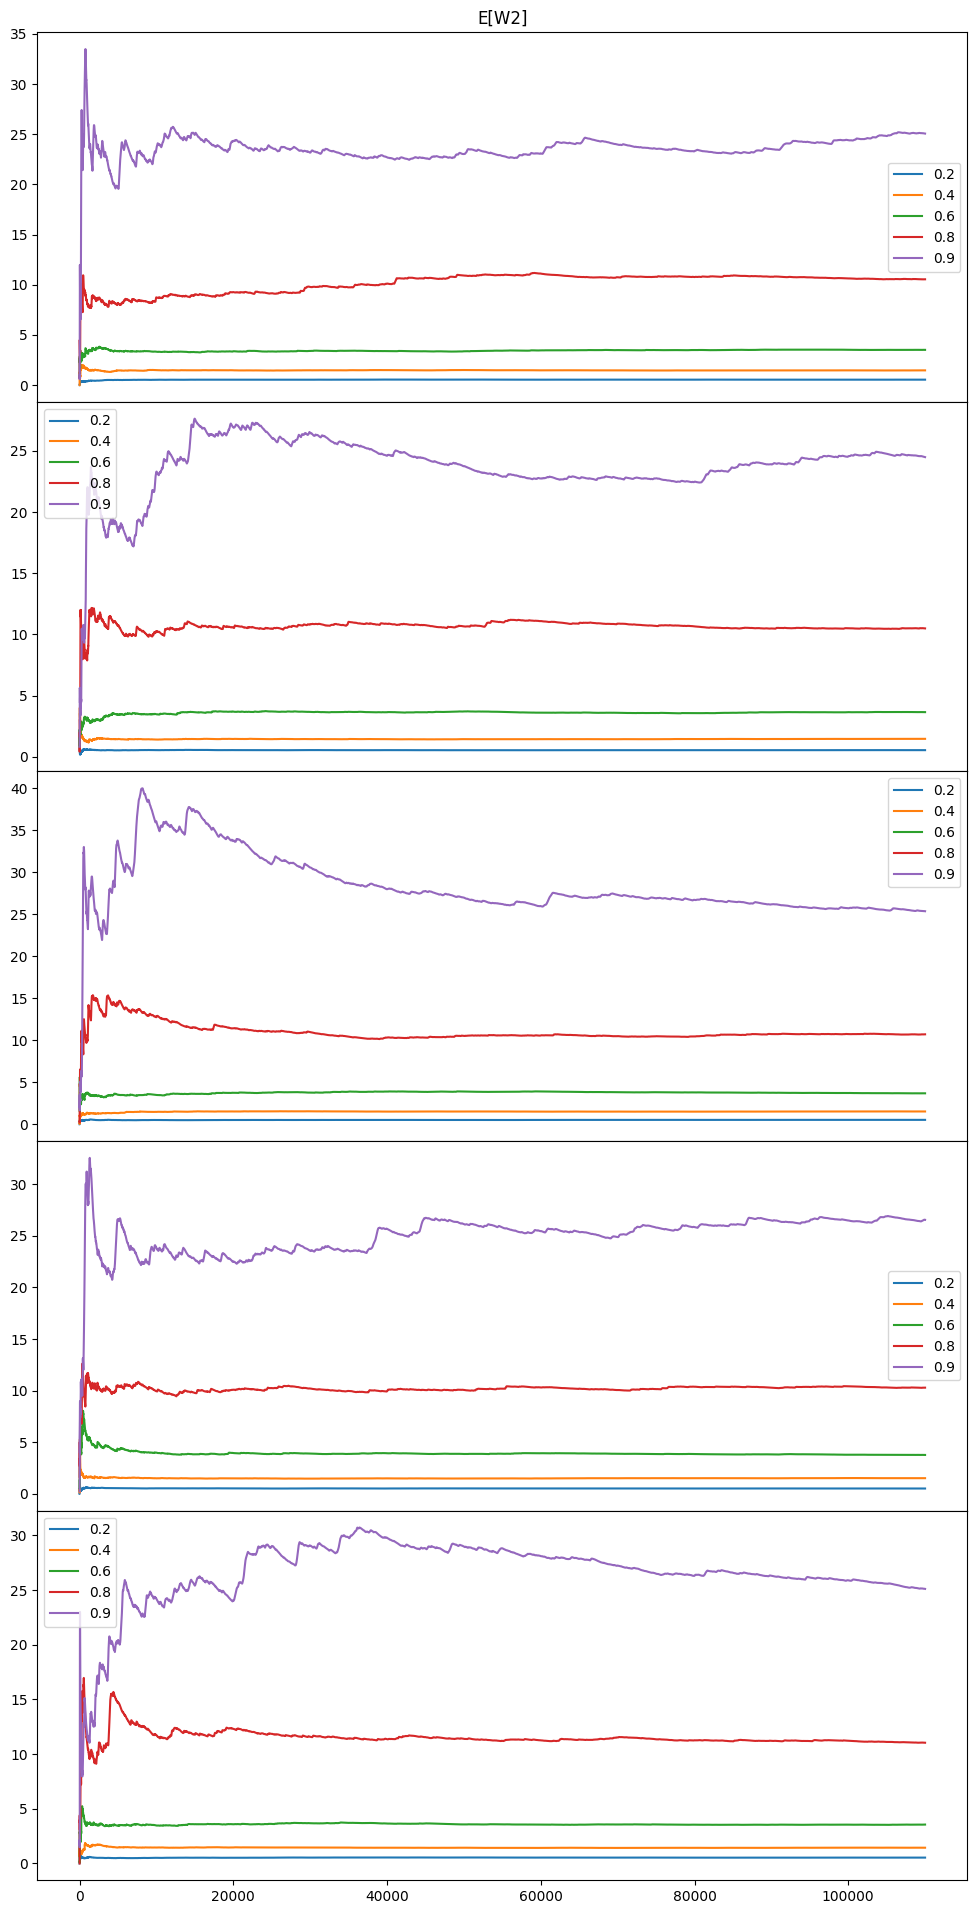

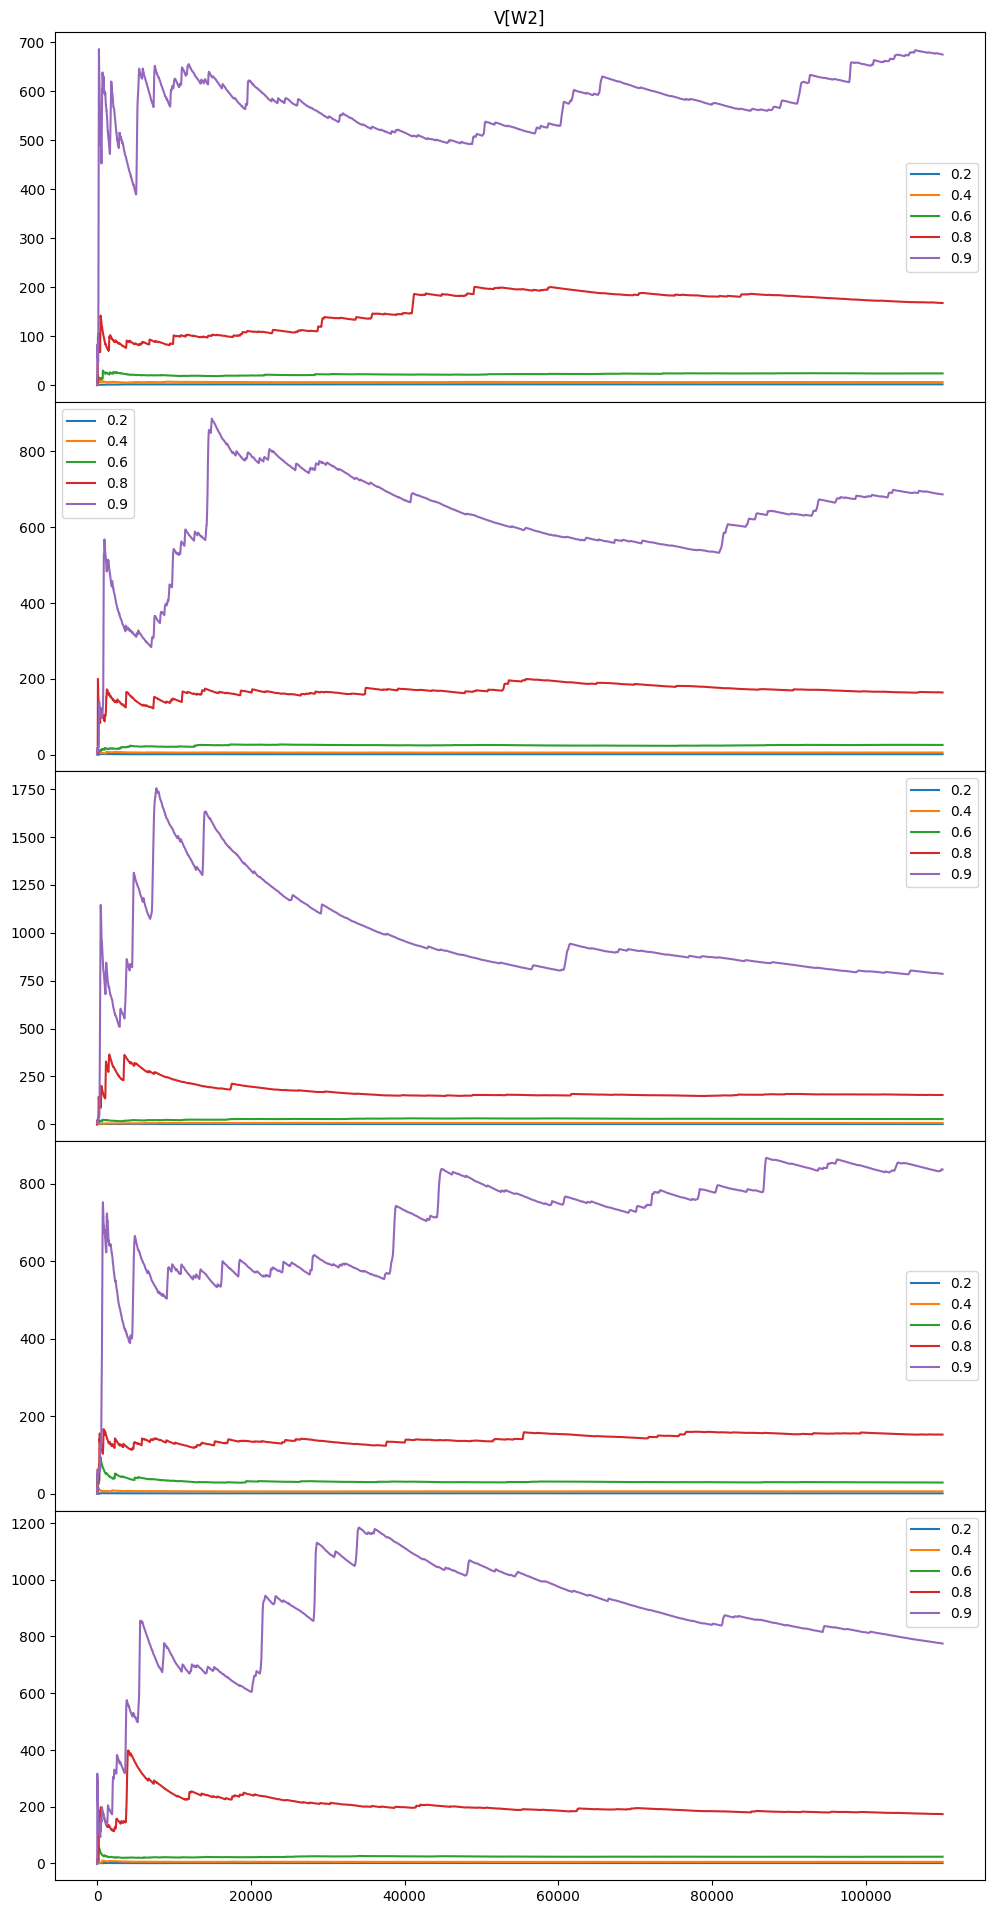

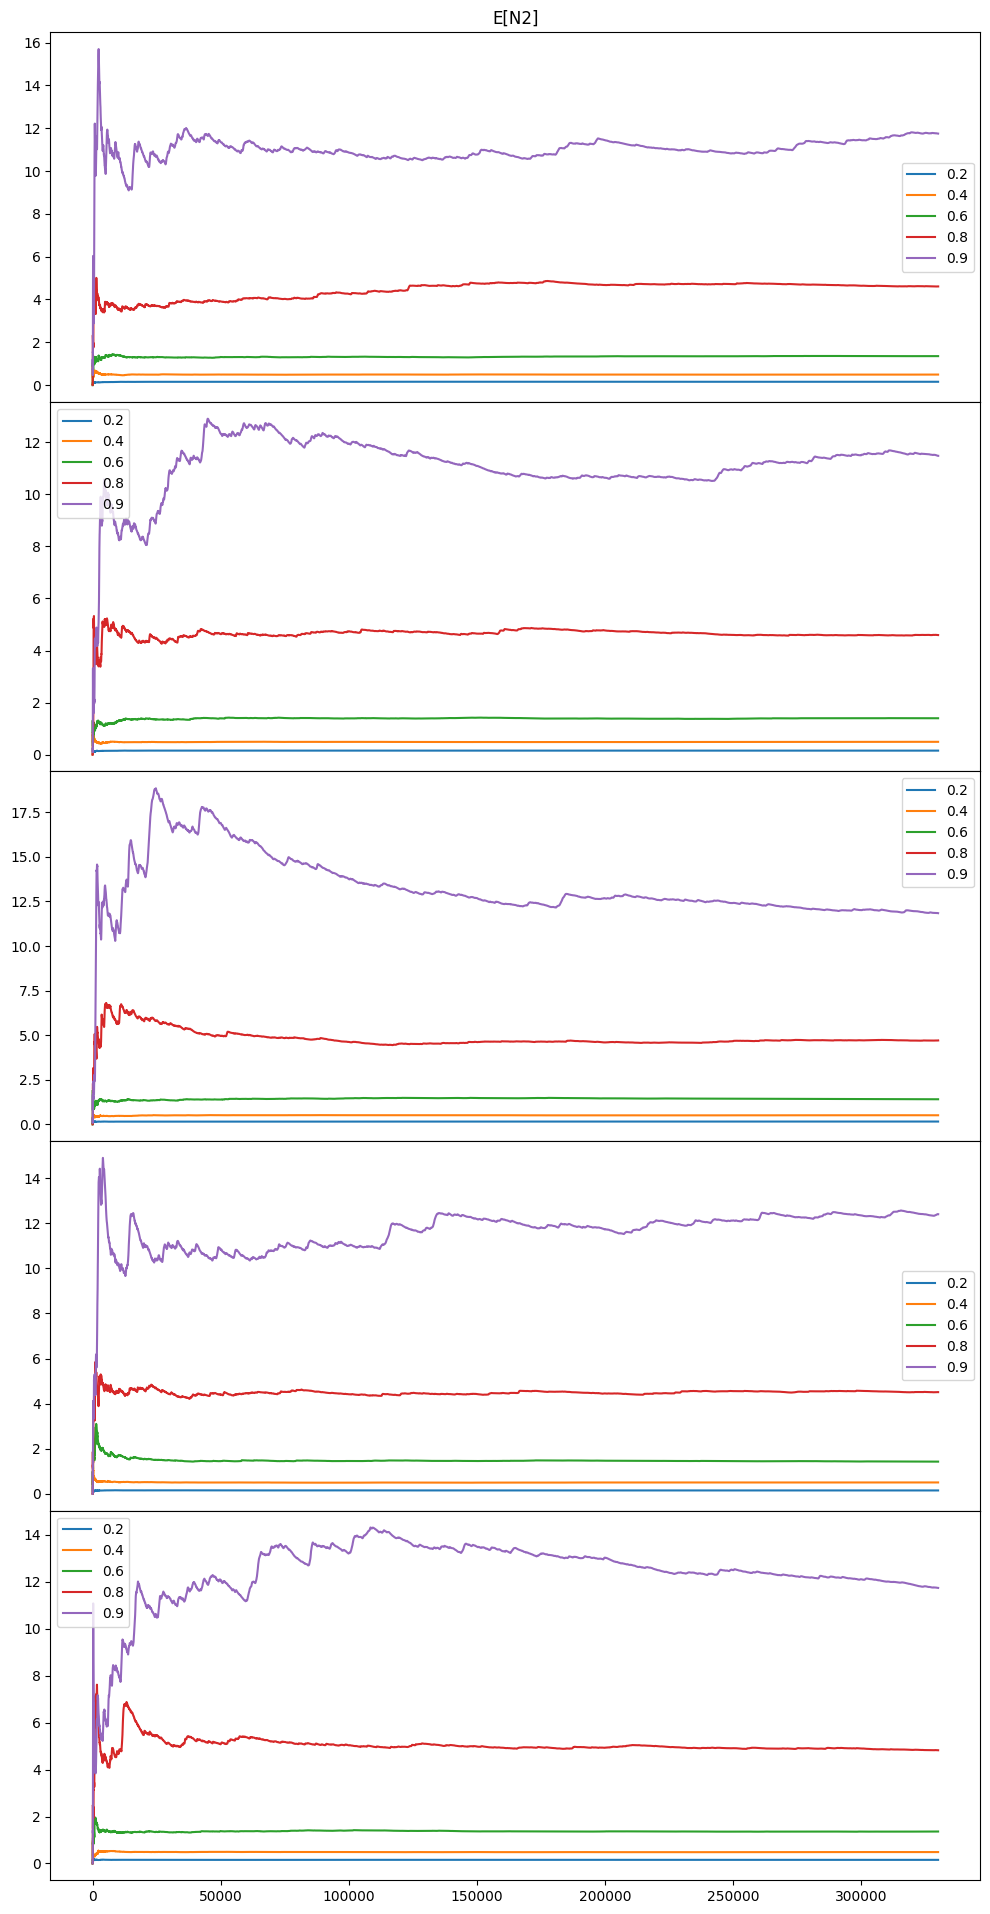

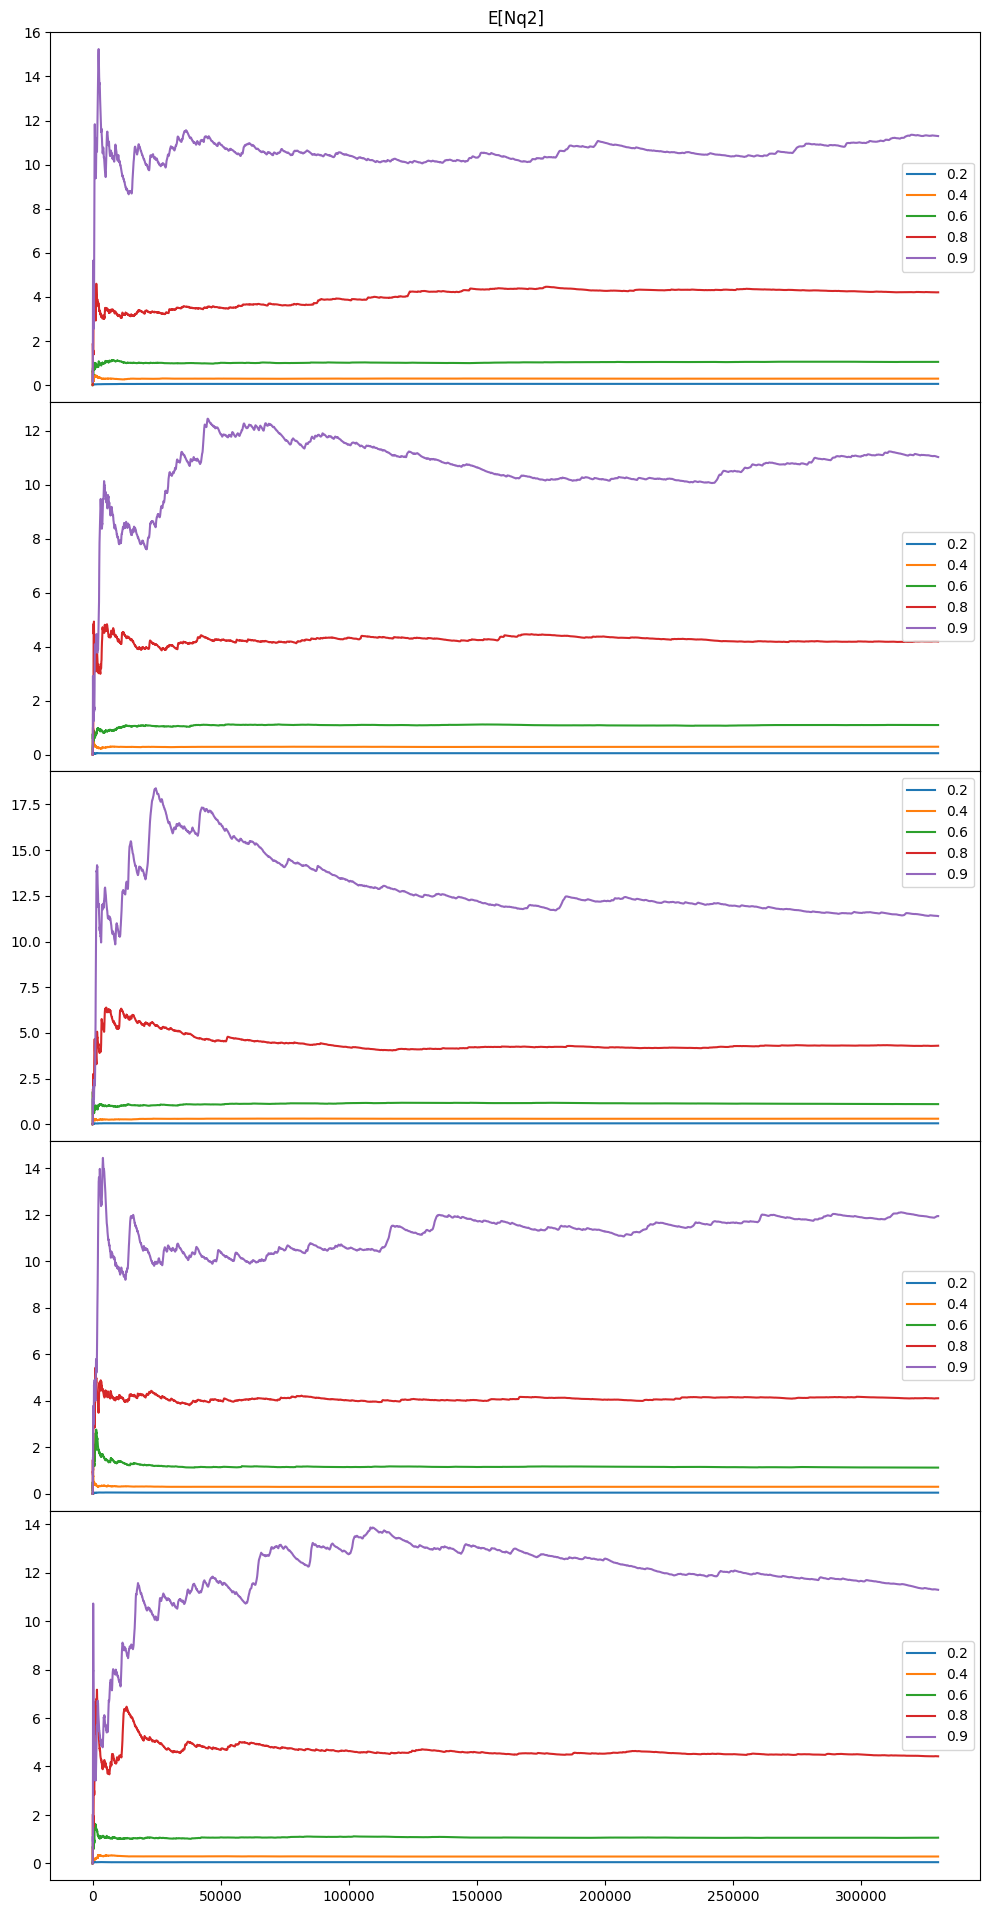

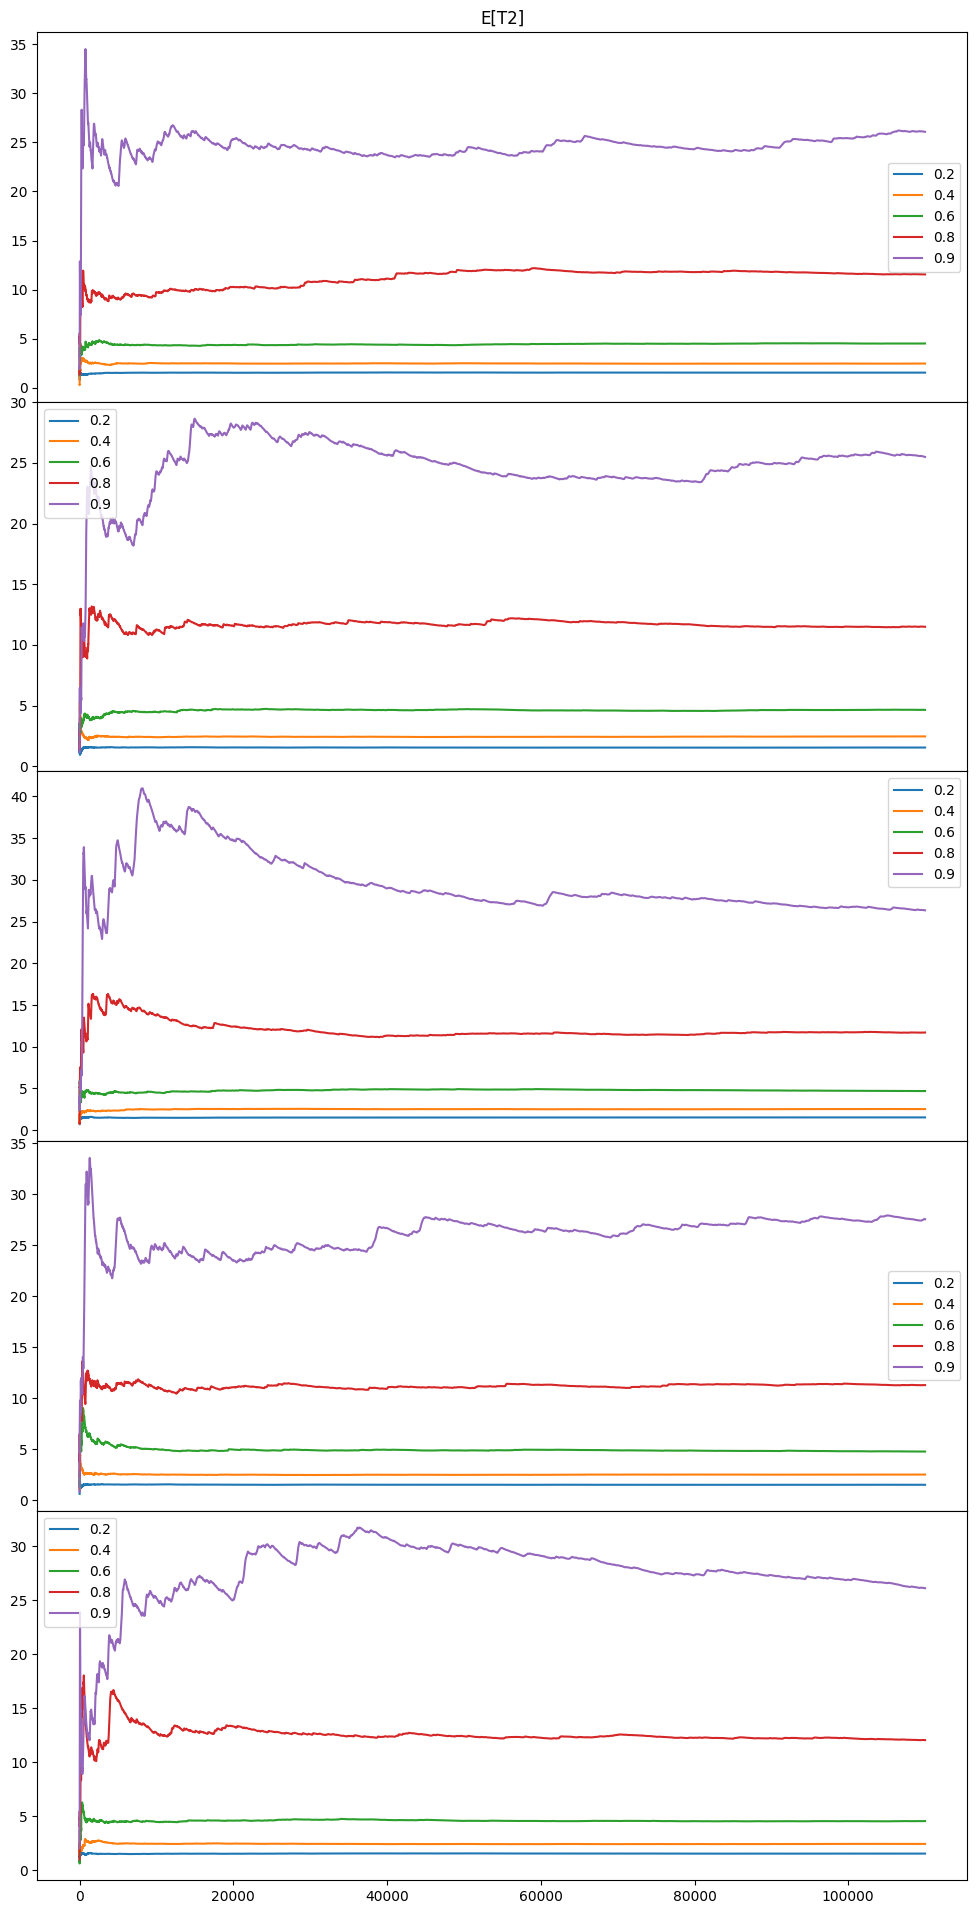

Plots demoraram 117.14 segundos


In [28]:
auxiliar_transiente(13, 110_000, 5)

Feito isso, olhamos para a métrica que mais demora para estabilizar (V[W2]) para a nossa decisão. Escolhemos usar os primeiros 200000 clientes como fase transiente.

### Coleta de resultados

Sabendo onde termina a fase transiente, vamos juntar tudo e adicionar a lógica de batch, onde cada simulação inicia onde a anterior termina. Escolhemos 100000 como o número de clientes por rodada e 10 rodadas por valor de rho

In [193]:
colunas = ["E[W1]", "V[W1]", "E[N1]", "E[Nq1]", "E[T1]", "E[W2]", "V[W2]", "E[N2]", "E[Nq2]", "E[T2]"]
valores = {
    "E[W1]": lambda rho: rho/(1-rho),
    "V[W1]": lambda rho: (rho/(1-rho))*(rho/(1-rho)+2),
    "E[N1]": lambda rho:  rho*valores["E[T1]"](rho),
    "E[Nq1]": lambda rho:  rho*valores["E[W1]"](rho),
    "E[T1]": lambda rho:  rho/(1-rho)+1,
    
    "E[W2]": lambda rho: valores["E[T2]"](rho) - 1,
    "E[N2]": lambda rho:  rho*valores["E[T2]"](rho),
    "E[Nq2]": lambda rho:  rho*valores["E[W2]"](rho),
    "E[T2]": lambda rho: (3*rho + 2 - 4*rho)/((1-2*rho)*(1-rho))- valores["E[T1]"](rho),
}
random.seed(13)

for r in RHOS:    
    mu = MU
    lamb = r/2
    print(r)
    
    arquivo = open(f"resultados/Rho={r}.csv", "w")
    for i in range(5): #número de testes diferentes
        print("Bateria de testes", i)
        start = time.time()
        
        rodadas = simulador_transiente(lamb, mu, 100_000, 6000, 3500, debug=False)
        metricas_gerais = {k: Estimador() for k in colunas}
        
        for rodada in rodadas:
            for c in colunas:
                metricas_gerais[c].adiciona_amostra( rodada[c[2:-1]].media() if c[0] == 'E' else rodada[c[2:-1]].variancia() )

        for c, est in metricas_gerais.items():
            if c == "V[W2]": continue
                
            _, t_sup, t_inf, t_prec = est.t_student()
            c_sup, c_inf, c_prec = est.chi_quadrado()
                
            if t_prec < 0.05 and c_prec < 0.05 and t_inf < valores[c](lamb) < t_sup and c_inf < valores[c](lamb) < c_sup:
                continue
            else:
                print("Erro na métrica", c)
        
        for k in metricas_gerais:
            print(k, end=';', file=arquivo, flush=True)
        print(file=arquivo, flush=True)
        
        for j, nome in enumerate(["Media", "Sup. T-student", "Inf. T-student", "Prec. T-student"]):
            print(nome, end =';', file=arquivo, flush=True)
            for k, v in metricas_gerais.items():
                print(f'{v.t_student()[j]:.4f}', end=';', file=arquivo, flush=True)
            print(file=arquivo, flush=True)
            
        for j, nome in enumerate(["Sup. Chi-Quadrado", "Inf. Chi-Quadrado", "Prec. Chi-Quadrado"]):
            print(nome, end =';', file=arquivo, flush=True)
            for k, v in metricas_gerais.items():
                #print(f'{v.chi_quadrado()[j] if k[0] == "E" else v.variancia_chi_quadrado()[j]:.4f}', end=';', file=arquivo, flush=True)
                print(f'{v.chi_quadrado()[j]:.4f}', end=';', file=arquivo, flush=True)
            print(file=arquivo, flush=True)
            
        print(f"Demorou {time.time() - start} segundos")
    print()

0.2
Bateria de testes 0
Demorou 504.1957461833954 segundos
Bateria de testes 1
Erro na métrica E[Nq1]
Demorou 505.5588159561157 segundos
Bateria de testes 2
Demorou 504.38453459739685 segundos
Bateria de testes 3
Erro na métrica E[N1]
Erro na métrica E[Nq1]
Erro na métrica E[N2]
Erro na métrica E[Nq2]
Demorou 505.79586839675903 segundos
Bateria de testes 4
Erro na métrica E[N1]
Erro na métrica E[W2]
Erro na métrica E[N2]
Erro na métrica E[Nq2]
Demorou 504.1941487789154 segundos

0.4
Bateria de testes 0
Demorou 514.7070159912109 segundos
Bateria de testes 1
Demorou 512.9180679321289 segundos
Bateria de testes 2
Erro na métrica E[W1]
Erro na métrica E[N1]
Erro na métrica E[Nq1]
Demorou 514.945475101471 segundos
Bateria de testes 3
Demorou 513.7722008228302 segundos
Bateria de testes 4
Demorou 515.1722722053528 segundos

0.6
Bateria de testes 0
Demorou 521.0688738822937 segundos
Bateria de testes 1
Demorou 522.1797869205475 segundos
Bateria de testes 2
Demorou 520.5634255409241 segundos
B

KeyboardInterrupt: 

## Testes de correção

Tratando o modelo de forma deterministica, podemos deduzir as fórmulas das médias de todos os valores usando $\lambda$ e $\mu$. Essa função retorna, respectivamente, os valores de espera na fila, tempo total e pessoas na fila para as filas 1 e 2. Na célula abaixo dessa, testamos os valores esperados com os atuais

In [55]:
# Essa função recebe lambda e mu, retornando os valores 
# de uma fila D/D/1
def testa_resultados(lambd, mu):
    rho_1 = lambd/mu
    x_1 = 1/mu
    xr = x_1*x_1/2*x_1
    w_1 = rho_1 * xr / (1 - rho_1)
    nq_1 = lambd * w_1
    t_1 = x_1 + w_1
    
    rho = 2*rho_1
    xr = (x_1 * x_1 + x_1 * x_1 + 2 * x_1 * x_1)/2*(x_1 + x_1)
    u = rho * xr / (1 - rho)
    t = (u + x_1 + x_1)/(1 - rho_1)
    
    t_2 = t - t_1
    w_2 = t_2 - x_1
    nq_2 = lambd * w_2
    
    return [w_1, t_1, nq_1, w_2, t_2, nq_2]

Quando o $\lambda$ é consideravelmente pequeno, o comportamento esperado é:
- $\overline{W_1}$ tende à zero porque as chegadas escassas fazem com que todas as chegadas sejam servidas
- $\overline{W_2}$ tende a zero também, mas de forma mais lenta do que $\overline{W_1}$ por causa das interrupções que recebe
- $\overline{T_1}$ tende a $\mu$ por não ter tempo de fila, assim como $\overline{T_2}$
- O tempo de serviço total tende ao valor de $\mu$

In [57]:
resultado = simulador(1e-7, 1, 10, 10000)
esperado = testa_resultados(1e-7, 1)
print('{} esperado x atual = {} x {}'.format('W1', esperado[0], resultado[0]['W1'].media()))
print('{} esperado x atual = {} x {}'.format('T1', esperado[1], resultado[0]['T1'].media()))
print('{} esperado x atual = {} x {}'.format('Nq1', esperado[2], resultado[0]['Nq1'].media()))
print('{} esperado x atual = {} x {}'.format('W2', esperado[3], resultado[0]['W2'].media()))
print('{} esperado x atual = {} x {}'.format('T2', esperado[4], resultado[0]['T2'].media()))
print('{} esperado x atual = {} x {}'.format('Nq2', esperado[5], resultado[0]['Nq2'].media()))

W1 esperado x atual = 5.000000500000049e-08 x 1.1127435222176053e-07
T1 esperado x atual = 1.000000050000005 x 0.999886328125
Nq1 esperado x atual = 5.000000500000049e-15 x 0.0
W2 esperado x atual = 9.500002549067688e-07 x 1.8249952895463445e-08
T2 esperado x atual = 1.000000950000255 x 1.0011099365234375
Nq2 esperado x atual = 9.500002549067687e-14 x 0.0


Para $\lambda = 0.5$, enquanto os valores da primeira fila se mantém estáveis, os valores da segunda fila começam a aumentar de forma indeterminada, por conta das interrupções

In [44]:
resultado = simulador(0.5, 1, 10, 10000)
for metrica in ['W1','W2','T1', 'T2', 'Nq1', 'Nq2']:
    media = resultado[0][metrica].media()
    print("Media de {}: {}".format(metrica, media))

Media de W1: 0.8811291434376484
Media de W2: 209.91461665611985
Media de T1: 1.8782749147475988
Media de T2: 210.9007616764828
Media de Nq1: 0.43788543349932396
Media de Nq2: 110.2655080302081


## Otimização

In [89]:
random.seed(13)
lamb = 0.6/2
mu = MU

In [180]:
valores = {
    "E[W1]": lambda rho: rho/(1-rho),
    "V[W1]": lambda rho: (rho/(1-rho))*(rho/(1-rho)+2),
    "E[N1]": lambda rho:  rho*valores["E[T1]"](rho),
    "E[Nq1]": lambda rho:  rho*valores["E[W1]"](rho),
    "E[T1]": lambda rho:  rho/(1-rho)+1,
    
    "E[W2]": lambda rho: valores["E[T2]"](rho) - 1,
    "E[N2]": lambda rho:  rho*valores["E[T2]"](rho),
    "E[Nq2]": lambda rho:  rho*valores["E[W2]"](rho),
    "E[T2]": lambda rho: (3*rho + 2 - 4*rho)/((1-2*rho)*(1-rho))- valores["E[T1]"](rho),
}

valores["E[Nq2]"](0.1)

0.05277777777777773

### Número de rodadas

In [ ]:
#valores = {"E[W1]": 0.4286, "V[W1]": 1.041, "E[N1]": 0.4286, "E[Nq1]": 0.1286, "E[T1]": 1.4286, "E[W2]": 3.643, "E[N2]": 1.393, "E[Nq2]": 1.093, "E[T2]": 4.643}

def otima_rodada(lamb, mu):
    rodadas = simulador_transiente(lamb, mu, 200_000, 8000, 4000, debug=False)
    metricas_gerais = {k: Estimador() for k in valores}
        
    for i, rodada in enumerate(rodadas):
        for c in valores:
            metricas_gerais[c].adiciona_amostra( rodada[c[2:-1]].media() if c[0] == 'E' else rodada[c[2:-1]].variancia() )
            
        if i < 3000: continue
            
        for c, est in metricas_gerais.items():
            _, t_sup, t_inf, t_prec = est.t_student()
            c_sup, c_inf, c_prec = est.chi_quadrado()
                
            if t_prec < 0.05 and c_prec < 0.05 and t_inf < valores[c](lamb) < t_sup and c_inf < valores[c](lamb) < c_sup:
                continue
            else:
                break
        else:
            return i+1
            

In [166]:
random.seed(13)
otima_rodada(lamb, mu)

0.4285714285714286 0.42934045592324455 0.42750769069583305
1.0408163265306125 1.0445437379376552 1.0352432960516895
0.42857142857142855 0.4290386996328963 0.4281322313734145
0.1285714285714286 0.12885467263899372 0.12825667517711506
1.4285714285714286 1.4297553303022206 1.4273187930081488
3.6428571428571432 3.644289254920147 3.6248150298216313
1.392857142857143 1.394460656858588 1.387813330203759
1.092857142857143 1.0945112237053474 1.0881129801722045
4.642857142857143 4.643850787297472 4.624080403813879


3071

### Tamanho da rodada

Sabendo o número minimo de rodadas, agora vamos olhar para o tamanho mínimo. Para isso, iremos começar com 10 eventos de partidas como o tamanho e aumentar de 10 em 10 até encontrarmos o número mínimo de partidas por rodada respeitando os ICs.

In [196]:
#valores = {"E[W1]": 0.4286, "V[W1]": 1.041, "E[N1]": 0.4286, "E[Nq1]": 0.1286, "E[T1]": 1.4286, "E[W2]": 3.643, "E[N2]": 1.393, "E[Nq2]": 1.093, "E[T2]": 4.643}

def otima_tamanho(lamb, mu, n):
    mult = 1
    while True:
        rodadas = simulador_transiente(lamb, mu, 200_000, mult*400, n, debug=False)
        metricas_gerais = {k: Estimador() for k in valores}
        
        for i, rodada in enumerate(rodadas):
            for c in valores:
                metricas_gerais[c].adiciona_amostra( rodada[c[2:-1]].media() if c[0] == 'E' else rodada[c[2:-1]].variancia() )
            
        for c, est in metricas_gerais.items():
            _, t_sup, t_inf, t_prec = est.t_student()
            c_sup, c_inf, c_prec = est.chi_quadrado()
                
            if t_prec < 0.05 and c_prec < 0.05 and t_inf < valores[c](lamb) < t_sup and c_inf < valores[c](lamb) < c_sup:
                continue
            else:
                break
        else:
            return mult*400
        mult += 1

In [169]:
random.seed(13)
otima_tamanho(lamb, mu, 3071)

800

### Fase Transiente

Agora, para descobrirmos o tamanho mínimo da fase transiente, faremos parecido com o anterior. Partindo de 1000, aumentaremos de 1000 em mim a fase transiente até acharmos um valor que mantenha os resultados dentro do IC pedido.

In [197]:
#valores = {"E[W1]": 0.4286, "V[W1]": 1.041, "E[N1]": 0.4286, "E[Nq1]": 0.1286, "E[T1]": 1.4286, "E[W2]": 3.643, "E[N2]": 1.393, "E[Nq2]": 1.093, "E[T2]": 4.643}

def otima_transiente(lamb, mu, n, k):
    mult = 1
    while True:
        rodadas = simulador_transiente(lamb, mu, mult*10000, k, n, debug=False)
        metricas_gerais = {k: Estimador() for k in valores}
        
        for i, rodada in enumerate(rodadas):
            for c in valores:
                metricas_gerais[c].adiciona_amostra( rodada[c[2:-1]].media() if c[0] == 'E' else rodada[c[2:-1]].variancia() )
            
        for c, est in metricas_gerais.items():
            _, t_sup, t_inf, t_prec = est.t_student()
            c_sup, c_inf, c_prec = est.chi_quadrado()
                
            if t_prec < 0.05 and c_prec < 0.05 and t_inf < valores[c](lamb) < t_sup and c_inf < valores[c](lamb) < c_sup:
                continue
            else:
                break
        else:
            return mult*10000
        mult += 1

In [173]:
random.seed(13)
otima_transiente(lamb, mu, 3071, 800)

20000

### Garantindo independencia

Para garantir a independencia dos resultados, vamos executar cada um dos testes 20 vezes e utilizaremos os valores máximos encontrados em cada uma das etapas

In [198]:
def independencia(lamb, mu):
    #max_rodadas = 0
    #for i in range(10):
#        rodadas = otima_rodada(lamb, mu)
#        max_rodadas = max(max_rodadas, rodadas)
#        print("Teste rodada", i, "=", rodadas)
#    print("Número máximo de rodadas:", max_rodadas)
#    print()
    max_rodadas = 3071
    max_tamanho = 0
    for i in range(20):
        tamanho = otima_tamanho(lamb, mu, max_rodadas)
        max_tamanho = max(max_tamanho, tamanho)
        print("Teste tamanho", i, "=", tamanho)
    print("Maior tamanho necessário:", max_tamanho)
    print()

    max_transiente = 0
    for i in range(20):
        transiente = otima_transiente(lamb, mu, max_rodadas, max_tamanho)
        max_transiente = max(max_transiente, transiente)
        print("Teste transiente", i, "=", transiente)
    print("Maior tamanho necessário:", max_transiente)
    print()

In [ ]:
random.seed(13)
mu = MU
lamb = 0.6/2

independencia(lamb, mu)

Teste tamanho 0 = 800
Teste tamanho 1 = 800
